# 🐍 Web Traffic Anomaly Detection

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# 2. Load Dataset
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")  # Replace with actual file name
df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [ ]:
df.shape

(282, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

No null values found in the dataset


In [ ]:
# Remove duplicate rows
df_unique = df.drop_duplicates()

In [ ]:
# Convert time-related columns to datetime format
df_unique['creation_time'] = pd.to_datetime(df_unique['creation_time'])
df_unique['end_time'] = pd.to_datetime(df_unique['end_time'])
df_unique['time'] = pd.to_datetime(df_unique['time'])

In [ ]:
# Standardize text data (example: convert to lower case)
df_unique['src_ip_country_code'] = df_unique['src_ip_country_code'].str.upper()

In [ ]:
# Feature Engineering
# Duration
df_unique['duration'] = (df_unique['end_time'] - df_unique['creation_time']).dt.total_seconds()

In [ ]:
# Bytes ratio
df_unique['bytes_ratio'] = df_unique['bytes_out'] / (df_unique['bytes_in'] + 1)

In [ ]:
# Hour of the day
df_unique['hour'] = df_unique['creation_time'].dt.hour

In [ ]:
df_unique

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,duration,bytes_ratio,hour
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,2.318401,23
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,0.588296,23
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,0.472445,23
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,0.467411,23
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,2.128390,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,41336,13180,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,136.226.77.103,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 09:50:00+00:00,waf_rule,600.0,0.318843,9
278,3638,3190,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,165.225.26.101,DE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 09:50:00+00:00,waf_rule,600.0,0.876614,9
279,25207794,1561220,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 09:50:00+00:00,waf_rule,600.0,0.061934,9
280,5736,12114,2024-04-26 09:50:00+00:00,2024-04-26 10:00:00+00:00,165.225.209.4,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26 09:50:00+00:00,waf_rule,600.0,2.111557,9


In [ ]:
df_unique.describe()

,bytes_in,bytes_out,response.code,dst_port,duration,bytes_ratio,hour
count,2.820000e+02,2.820000e+02,282.0,282.0,282.0,282.000000,282.000000
mean,1.199390e+06,8.455429e+04,200.0,443.0,600.0,1.305889,8.478723
std,4.149312e+06,2.549279e+05,0.0,0.0,0.0,1.169405,8.235496
min,4.000000e+01,4.400000e+01,200.0,443.0,600.0,0.018153,0.000000
25%,5.381500e+03,1.114200e+04,200.0,443.0,600.0,0.472628,1.000000
50%,1.318200e+04,1.379950e+04,200.0,443.0,600.0,0.893332,8.000000
75%,3.083300e+04,2.627950e+04,200.0,443.0,600.0,1.989029,9.000000
max,2.520779e+07,1.561220e+06,200.0,443.0,600.0,6.518519,23.000000


* **bytes_in and bytes_out show a high variance**, with the mean values of around 1.2 million and 84.5 thousand, respectively, indicating that there are large differences in the traffic volume across the dataset. The presence of large values in these features could suggest anomalies or network irregularities, as the data spans multiple orders of magnitude.
* **bytes_ratio has a high mean of 1.31**, suggesting that the incoming data (bytes_in) is often significantly larger than outgoing data (bytes_out), which is typical for scenarios like downloading large files or receiving heavy traffic while only responding minimally.

* hour has a mean of **8.48**, indicating that most traffic is observed during business hours (early to late morning). The hours seem to follow a typical business traffic pattern.

In [ ]:
#Top Source IPs and Destination IPs
top_src_ips = df_unique['src_ip'].value_counts().head(10)
top_dst_ips = df_unique['dst_ip'].value_counts().head(10)

In [ ]:
top_src_ips

,count
src_ip,
165.225.209.4,29
165.225.26.101,28
155.91.45.242,28
136.226.67.101,28
147.161.131.1,21
165.225.240.79,18
136.226.77.103,17
147.161.161.82,16
165.225.212.255,15


*  The distribution of source IPs reveals that a few IP addresses dominate the traffic, with IP 165.225.209.4 being the most frequent, appearing 29 times. This could indicate a concentration of traffic from specific sources, possibly suggesting either high legitimate traffic or a potential botnet or DDoS attack if a single IP is responsible for many requests.

*  Other frequent source IPs (like 165.225.26.101 and 155.91.45.242) appearing 28 times and 28 times respectively, further suggest that multiple source IPs are contributing significantly to the traffic, which might be useful for identifying potential suspicious activity based on unusual IP patterns.

In [ ]:
top_dst_ips

,count
dst_ip,
10.138.69.97,282


All the traffic is directed to the same destination IP (10.138.69.97), which may represent a single web server or a protected system that could be the primary target of the traffic.

<ipython-input-16-24110464db2f>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_unique['bytes_total'].resample('H').sum().plot(figsize=(15, 4), title="Total Traffic Over Time (Hourly)")


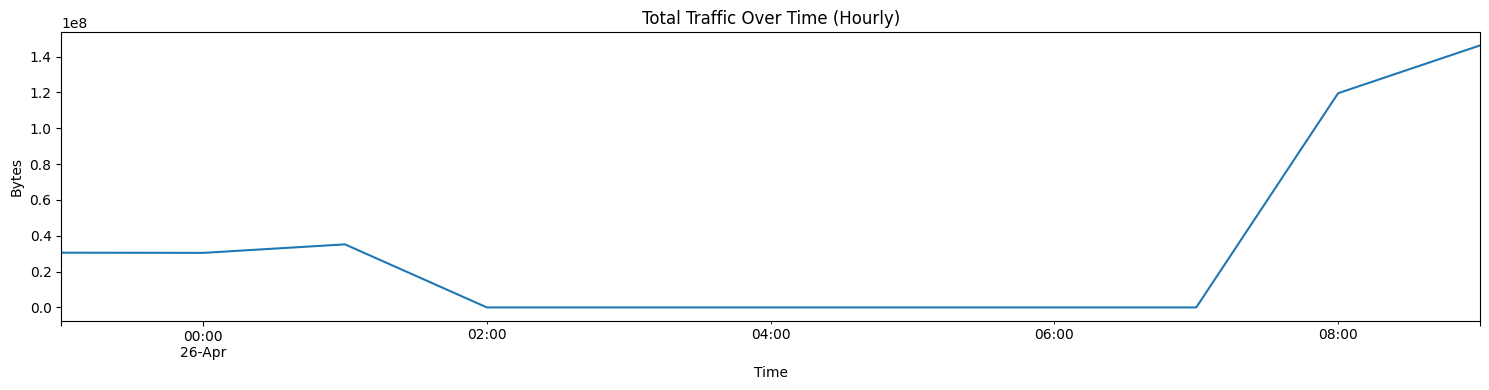

In [ ]:
#Traffic Over Time
df_unique.set_index('time', inplace=True)
df_unique['bytes_total'] = df_unique['bytes_in'] + df_unique['bytes_out']
df_unique['bytes_total'].resample('H').sum().plot(figsize=(15, 4), title="Total Traffic Over Time (Hourly)")
plt.xlabel("Time")
plt.ylabel("Bytes")
plt.tight_layout()
plt.show()
df_unique.reset_index(inplace=True)

* **Initial Stable Traffic**: The traffic remains stable at around 300 million bytes from midnight to 01:00.

* **Sudden Drop to Zero**: Traffic drops sharply between 01:00 and 07:00, possibly indicating a network maintenance window or a failure.

* **Significant Traffic Surg**e: At 07:00, a massive traffic spike begins, possibly indicating a scheduled event (such as users logging in) or potential cyber attack like DDoS or data exfiltration.

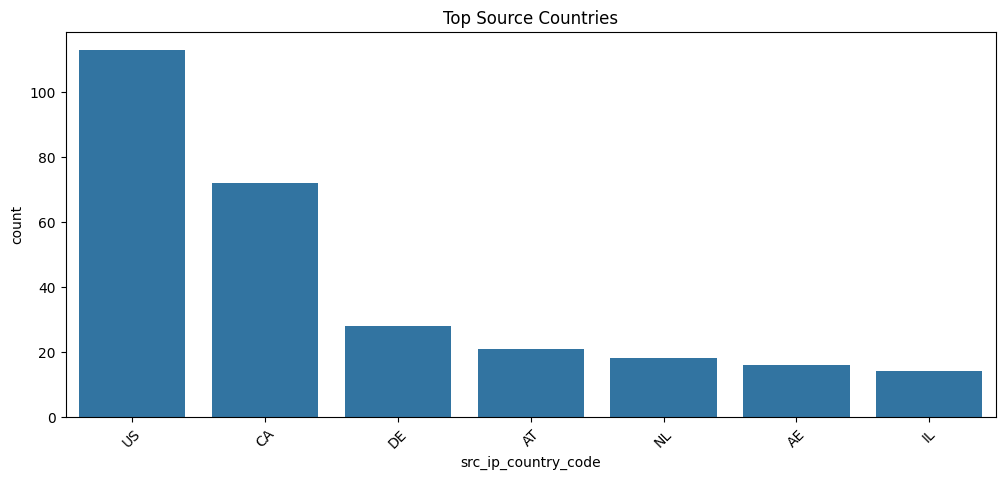

In [ ]:
# Country Code Analysis
plt.figure(figsize=(12, 5))
sns.countplot(data=df_unique, x='src_ip_country_code', order=df['src_ip_country_code'].value_counts().head(10).index)
plt.title("Top Source Countries")
plt.xticks(rotation=45)
plt.show()

* **United States** (US) is the dominant source of the traffic, contributing a significant majority of the total network connections. This might indicate either legitimate user activity or the presence of geographically dispersed attackers using US-based proxies.

* **Canada** (CA) ranks second but with a much smaller proportion of total connections, followed by other countries like Germany, Austria, and Netherlands.

**Implication for Cybersecurity:** This distribution is useful for identifying anomalous traffic patterns. If the US is normally the top contributor, a sudden spike from countries with low traffic might indicate a breach, potentially coming from a different region or an attack leveraging compromised servers in other countries.

<ipython-input-18-8d5c3cc4fc82>:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  traffic_resampled = df_unique[['bytes_in', 'bytes_out']].resample('H').sum()


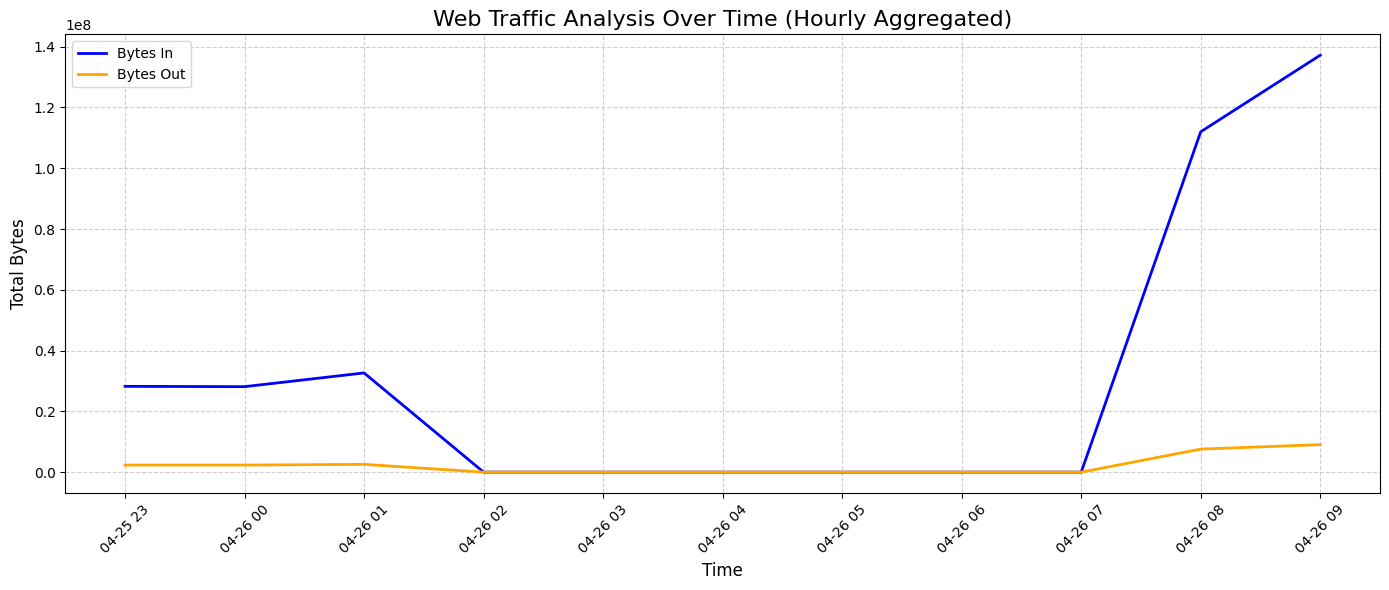

In [ ]:
# Convert 'creation_time' to datetime format
df_unique['creation_time'] = pd.to_datetime(df_unique['creation_time'])

# Set 'creation_time' as the index for time-based operations
df_unique.set_index('creation_time', inplace=True)

# Optional: Resample by hour to smooth the trend (can change to 'D' for daily)
traffic_resampled = df_unique[['bytes_in', 'bytes_out']].resample('H').sum()

# Plotting bytes in and out over time
plt.figure(figsize=(14, 6))
plt.plot(traffic_resampled.index, traffic_resampled['bytes_in'], label='Bytes In', color='blue', linewidth=2)
plt.plot(traffic_resampled.index, traffic_resampled['bytes_out'], label='Bytes Out', color='orange', linewidth=2)

# Formatting the plot
plt.title('Web Traffic Analysis Over Time (Hourly Aggregated)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Total Bytes', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Reset index if needed for further processing
df_unique.reset_index(inplace=True)


**Interpretation from a Cybersecurity Perspective:**

* Scheduled Maintenance/Outage: The drop in both incoming and outgoing traffic between 01:00 and 07:00 likely represents a period of server downtime or maintenance.

* Potential Cyberattack:

    *    DDoS Attack: The massive spike in incoming traffic after 07:00 strongly suggests the possibility of a DDoS attack.

    * Malicious Uploads or Exploit Attempts: The volume of incoming traffic could also indicate attempted exploitation or uploading malicious files.

    * Exfiltration or Secondary Effects: The increase in outgoing traffic could suggest that data is being exfiltrated or other malicious outbound communications are occurring in response to the influx of incoming traffic.

While there is an increase in traffic related to the start of the workday, the magnitude and suddenness of the traffic spike make it more likely that this is malicious activity rather than just a natural increase in legitimate traffic.

# Unsupervised Anomaly Detection (Isolation Forest)

In [ ]:
# Copy the original data to avoid modifying in place
encoded_data = df_unique.copy()

In [ ]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   creation_time        282 non-null    datetime64[ns, UTC]
 1   time                 282 non-null    datetime64[ns, UTC]
 2   bytes_in             282 non-null    int64              
 3   bytes_out            282 non-null    int64              
 4   end_time             282 non-null    datetime64[ns, UTC]
 5   src_ip               282 non-null    object             
 6   src_ip_country_code  282 non-null    object             
 7   protocol             282 non-null    object             
 8   response.code        282 non-null    int64              
 9   dst_port             282 non-null    int64              
 10  dst_ip               282 non-null    object             
 11  rule_names           282 non-null    object             
 12  observation_name     2

In [ ]:
# Define categorical columns to encode
cat_cols = ['protocol', 'src_ip','src_ip_country_code', 'rule_names',
            'observation_name', 'source.meta', 'source.name', 'dst_ip',
            'detection_types']

In [ ]:
# Apply LabelEncoder to each column
for col in cat_cols:
    encoder = LabelEncoder()
    encoded_data[col] = encoder.fit_transform(encoded_data[col].astype(str))

In [ ]:
encoded_data.head()

,creation_time,time,bytes_in,bytes_out,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,detection_types,duration,bytes_ratio,hour,bytes_total
0,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,5602,12990,2024-04-25 23:10:00+00:00,5,0,0,200,443,0,0,0,0,0,0,600.0,2.318401,23,18592
1,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,30912,18186,2024-04-25 23:10:00+00:00,12,6,0,200,443,0,0,0,0,0,0,600.0,0.588296,23,49098
2,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,28506,13468,2024-04-25 23:10:00+00:00,8,2,0,200,443,0,0,0,0,0,0,600.0,0.472445,23,41974
3,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,30546,14278,2024-04-25 23:10:00+00:00,0,6,0,200,443,0,0,0,0,0,0,600.0,0.467411,23,44824
4,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,6526,13892,2024-04-25 23:10:00+00:00,10,5,0,200,443,0,0,0,0,0,0,600.0,2.128390,23,20418


In [ ]:
# Drop features with only one unique value
nunique = encoded_data.nunique()
zero_variance_cols = nunique[nunique == 1].index.tolist()

print("Dropping zero-variance columns:", zero_variance_cols)

Dropping zero-variance columns: ['protocol', 'response.code', 'dst_port', 'dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name', 'detection_types', 'duration']


In [ ]:
# Drop from both original and encoded datasets
data_cleaned = df_unique.drop(columns=zero_variance_cols)
encoded_data_cleaned = encoded_data.drop(columns=zero_variance_cols)

In [ ]:
encoded_data_cleaned.head()

,creation_time,time,bytes_in,bytes_out,end_time,src_ip,src_ip_country_code,bytes_ratio,hour,bytes_total
0,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,5602,12990,2024-04-25 23:10:00+00:00,5,0,2.318401,23,18592
1,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,30912,18186,2024-04-25 23:10:00+00:00,12,6,0.588296,23,49098
2,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,28506,13468,2024-04-25 23:10:00+00:00,8,2,0.472445,23,41974
3,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,30546,14278,2024-04-25 23:10:00+00:00,0,6,0.467411,23,44824
4,2024-04-25 23:00:00+00:00,2024-04-25 23:00:00+00:00,6526,13892,2024-04-25 23:10:00+00:00,10,5,2.128390,23,20418


In [ ]:
encoded_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   creation_time        282 non-null    datetime64[ns, UTC]
 1   time                 282 non-null    datetime64[ns, UTC]
 2   bytes_in             282 non-null    int64              
 3   bytes_out            282 non-null    int64              
 4   end_time             282 non-null    datetime64[ns, UTC]
 5   src_ip               282 non-null    int64              
 6   src_ip_country_code  282 non-null    int64              
 7   bytes_ratio          282 non-null    float64            
 8   hour                 282 non-null    int32              
 9   bytes_total          282 non-null    int64              
dtypes: datetime64[ns, UTC](3), float64(1), int32(1), int64(5)
memory usage: 21.1 KB


In [ ]:
# Select only numeric columns
numeric_cols = encoded_data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Make sure no datetime columns sneak in
features = ['bytes_in', 'bytes_out', 'bytes_ratio', 'hour'] + [col for col in numeric_cols if col not in ['bytes_in', 'bytes_out', 'bytes_ratio', 'hour']]

In [ ]:
X = encoded_data_cleaned[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
data_cleaned['anomaly'] = model.fit_predict(X_scaled)
data_cleaned['anomaly'] = data_cleaned['anomaly'].map({1: 0, -1: 1})  # 1: anomaly

In [ ]:
print("Total anomalies:", data_cleaned['anomaly'].sum())
print("Percentage anomalies: {:.2f}%".format(data_cleaned['anomaly'].mean() * 100))

Total anomalies: 15
Percentage anomalies: 5.32%


* Anomaly Rate: The 5.32% anomaly rate aligns with the contamination parameter of 0.05 (5%), suggesting the Isolation Forest model is performing as expected in identifying suspicious behavior.

* Significance: Out of 282 total entries, only 15 anomalies were detected, indicating that the model is appropriately flagging unusual behaviors while keeping false positives low.

In [ ]:
top_ips = data_cleaned[data_cleaned['anomaly'] == 1]['src_ip'].value_counts().head(10)
print("Top suspicious IPs:\n", top_ips)

Top suspicious IPs:
 src_ip
155.91.45.242     13
192.241.230.19     1
165.225.240.79     1
Name: count, dtype: int64




*   One IP (155.91.45.242) accounts for 13 out of 15 anomalies — this is very suspicious.
*   This IP may be scanning or probing your server repeatedly. It’s a great candidate for blocking or deeper forensic analysis.

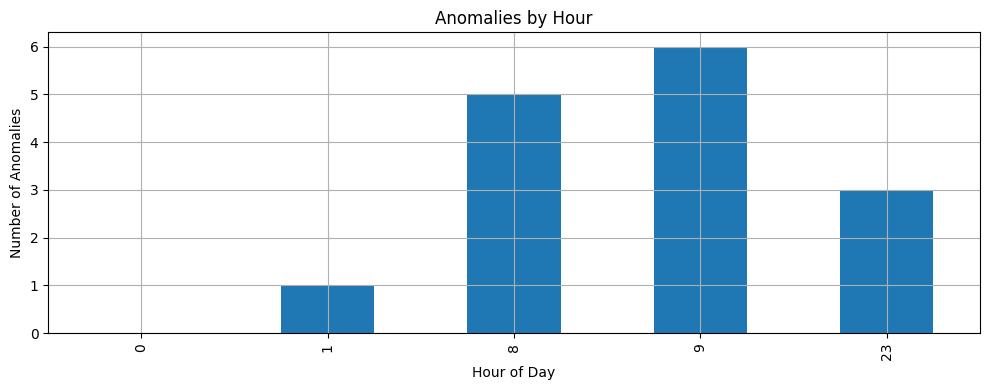

In [ ]:
import matplotlib.pyplot as plt

hourly = data_cleaned.groupby('hour')['anomaly'].sum()
hourly.plot(kind='bar', title='Anomalies by Hour', figsize=(10,4), grid=True)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Anomalies')
plt.tight_layout()
plt.show()


* Most suspicious activity occurred between 8:00 and 9:00 — this may indicate an automated job or bot.

* These hours can be monitored closely in real-time systems.

In [ ]:
# Suspicious traffic by country
country_anomalies = data_cleaned[data_cleaned['anomaly'] == 1]['src_ip_country_code'].value_counts()
print("Anomalies by Country:\n", country_anomalies)

# Avg traffic per IP
avg_traffic = data_cleaned.groupby('src_ip')[['bytes_in', 'bytes_out']].mean()


Anomalies by Country:
 src_ip_country_code
US    14
NL     1
Name: count, dtype: int64


# **CONCLUSIONS:**
* ## High bytes_in combined with relatively low bytes_out observed in multiple sessions suggests potential data infiltration or beaconing activity, where large volumes of data are entering the network with limited response back.

* ## Frequent and repeated interactions from specific source IPs—notably 155.91.45.242, 165.225.209.4, and 165.225.26.101—highlight possible automated scanning, brute force attempts, or botnet-driven behavior.

* ## Nearly all traffic originated from the United States, indicating possible use of U.S.-based proxies or cloud infrastructure to launch or mask malicious activities, commonly seen in sophisticated threat campaigns.

* ## The drop in traffic to zero between 1:00 AM and 7:00 AM followed by a sharp increase suggests either planned downtime or a potential lull period exploited by attackers to evade detection and time their activity for when monitoring resumes.

* ## Peak anomaly hours at 8:00 and 9:00 AM correlate with the start of business operations, potentially indicating attempts to blend in with normal user behavior or trigger attacks when user traffic surges.

* ## Although dst_port and response.code are constant (443 and 200 respectively), the high variance in bytes_ratio continues to serve as a strong indicator of imbalanced or suspicious communication flows.